<a href="https://colab.research.google.com/github/npgeorge/DS-Unit-2-Applied-Modeling/blob/master/NHL_Data_Project_Team_Stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NHL Data Project


#Answers

Choose your target. Which column in your tabular dataset will you predict?

I will predict on the "won" column for the Boston Bruins first, and apply that model to all teams.

Is your problem regression or classification?

Regression, win or loss is binary. I could try classification as well. 

How is your target distributed?

Regression: Is the target right-skewed? If so, you may want to log transform the target. TBD. 


Choose which observations you will use to train, validate, and test your model.

    - Are some observations outliers? Will you exclude them? TBD
    - Will you do a random split or a time-based split? Random. 


Choose your evaluation metric(s).
    - Classification: Is your majority class frequency > 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
- Begin to clean and explore your data.
- Begin to choose which features, if any, to exclude. Would some features "leak" future information?

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
file_path = '/content/gdrive/My Drive/Lambda School/NHL Project/game_teams_stats.csv'

In [0]:
df = pd.read_csv(file_path)

In [6]:
df.head()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways
0,2011030221,1,away,False,OT,Peter DeBoer,3,26,31,12,3,1,44.9,6,7
1,2011030221,4,home,True,OT,Peter Laviolette,4,36,27,6,6,1,55.1,13,4
2,2011030222,1,away,True,REG,Peter DeBoer,4,35,32,12,4,0,50.9,8,7
3,2011030222,4,home,False,REG,Peter Laviolette,1,20,24,32,5,0,49.1,9,6
4,2011030223,4,away,False,OT,Peter Laviolette,3,28,28,4,5,1,50.8,2,1


In [7]:
#bruins
#if a model works for one team, it *could* work broadly for others
#this may turn out to be a bad assumption
#this filter returns the df for the Bruins
#or statement for home and away games

bruins_id_condition = df['team_id'] == 6 #(df['home_team_id'] == 6) | (df['away_team_id'] == 6)
df_bruins = df[bruins_id_condition]
df_bruins.shape

(812, 15)

In [8]:
#baseline, can we beat the Bruins baseline target?
baseline_target = 'won'
y_baseline = df_bruins[baseline_target]
y_baseline.value_counts(normalize=True) 

True     0.57266
False    0.42734
Name: won, dtype: float64

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
#train, test
train, test = train_test_split(df_bruins, 
                               train_size=0.80, 
                               test_size=0.20,
                               stratify=df_bruins['won'], 
                               random_state=42)
train.shape, test.shape

((649, 15), (163, 15))

In [10]:
#train, val
train, val = train_test_split(train, 
                              train_size=0.80, 
                              test_size=0.20, 
                              stratify=train['won'], 
                              random_state=42)
train.shape, val.shape

((519, 15), (130, 15))

In [0]:
#target and features
target = 'won'
#drop target 
train_features = train.drop(columns=[target])
#numeric features
num_feat = train_features.select_dtypes(include='number').columns.tolist()
#Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()
#Get a list of all categorical features with cardinality <= 60
cat_feat = cardinality[cardinality <= 60].index.tolist()
# Combine the lists 
features = num_feat + cat_feat

In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [13]:
!pip install category_encoders

     |████████████████████████████████| 102kB 3.7MB/s 


In [14]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, 
                           n_jobs=-1, 
                           min_samples_leaf=1, 
                           max_depth=7, 
                           class_weight='balanced',
                           max_features=8, 
                           )
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on Train/Val
print('Training Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

# Predict on Test Data
y_pred_rfc = pipeline.predict(X_test)

Training Accuracy 0.9402697495183044
Validation Accuracy 0.8


In [15]:
from sklearn.metrics import accuracy_score
print('Test Accuracy for Random Forest', accuracy_score(y_test, y_pred_rfc))

Test Accuracy for Random Forest 0.7361963190184049


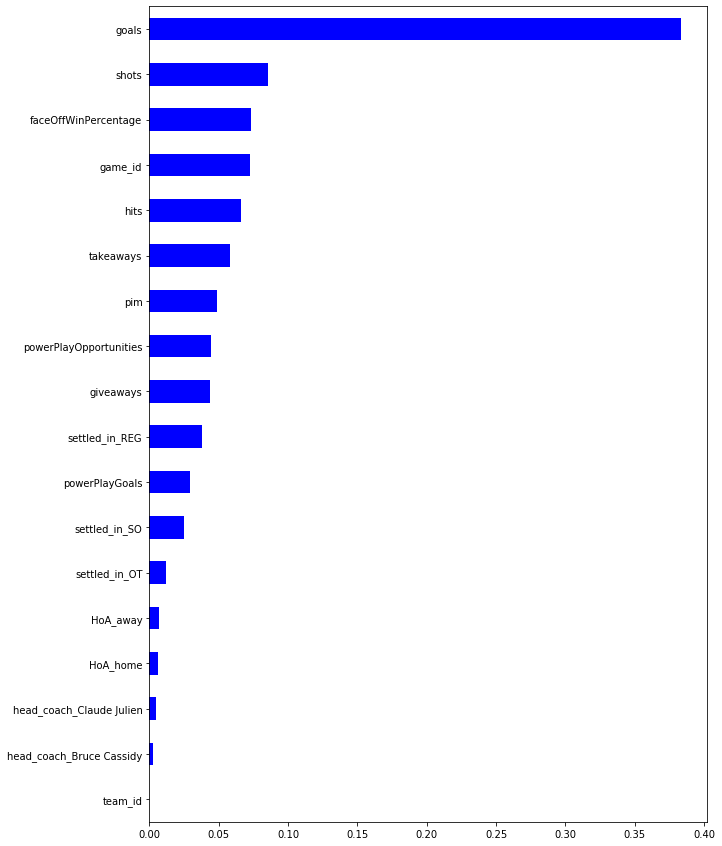

In [16]:
#feature importances
model = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,15))
importances.sort_values().plot.barh(color='blue');

In [23]:
#with XG Boost
from xgboost import XGBClassifier

pipeline_xgb = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline_xgb.fit(X_train, y_train)
print('Validation Accuracy:', pipeline_xgb.score(X_val, y_val))

#predict on test
y_pred_xgb = pipeline_xgb.predict(X_test)

Validation Accuracy: 0.7461538461538462


In [24]:
print('Test Accuracy for XG Boost', accuracy_score(y_test, y_pred_xgb))

Test Accuracy for XG Boost 0.6993865030674846


In [25]:
#permutation importance 
pipeline_pi = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed = pipeline_pi.fit_transform(X_train)
X_val_transformed = pipeline_pi.transform(X_val)


model_pi = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model_pi.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [27]:
!pip install eli5

In [28]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model_pi,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)
permuter.fit(X_val_transformed, y_val)

Using TensorFlow backend.


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                     

In [29]:
permuter.feature_importances_

array([0.00923077, 0.        , 0.26307692, 0.02615385, 0.00461538,
       0.01230769, 0.01538462, 0.02153846, 0.00923077, 0.01076923,
       0.02153846, 0.00153846, 0.00153846, 0.01230769])

In [30]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_val.columns.tolist()
)

Weight,Feature
0.2631 ± 0.0587,goals
0.0262 ± 0.0123,shots
0.0215 ± 0.0282,powerPlayGoals
0.0215 ± 0.0329,takeaways
0.0154 ± 0.0218,powerPlayOpportunities
0.0123 ± 0.0157,head_coach
0.0123 ± 0.0209,pim
0.0108 ± 0.0209,giveaways
0.0092 ± 0.0314,faceOffWinPercentage
0.0092 ± 0.0265,game_id


In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [32]:
!pip install pdpbox

     |████████████████████████████████| 57.7MB 40kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690723 sha256=385f8a2518ded59ea450a73b2d955cb7cb00feb478806b0fa1323f3c727349b0
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

In [0]:
feature='faceOffWinPercentage'

isolated = pdp_isolate(
    model = pipeline_xgb,
    dataset = X_val,
    model_features = X_val.columns,
    feature = feature
)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f92e1160a90>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f92e11fb208>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


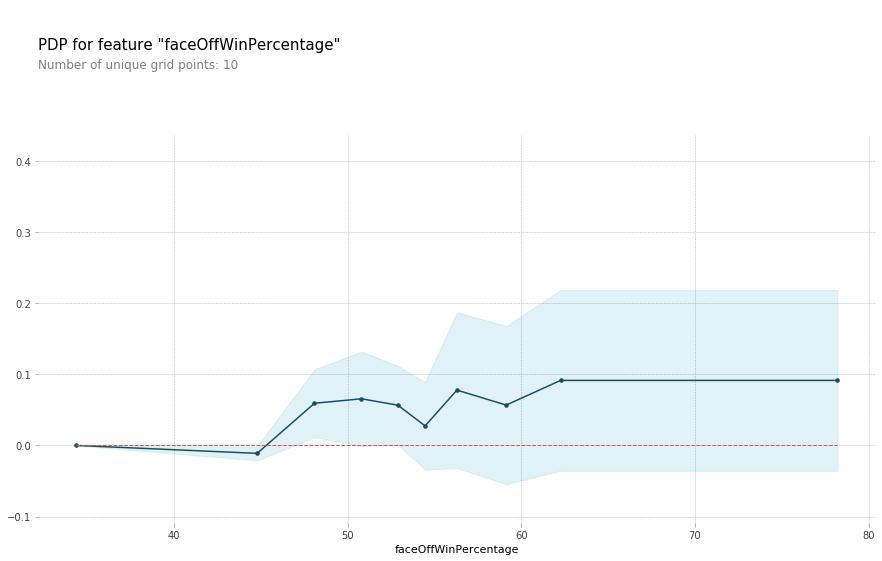

In [37]:
pdp_plot(isolated, feature_name=feature)